# Grammar Scoring Engine
# Predicting Grammar Score from Audio Data


# Importing the libraries

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')


# Loading the Dataset

In [52]:
import pandas as pd

# Load CSVs
train_df = pd.read_csv("dataset/dataset/train.csv")
test_df = pd.read_csv("dataset/dataset/test.csv")
sample_submission = pd.read_csv("dataset/dataset/sample_submission.csv")

# Display info
print("Train Set:")
display(train_df.head())

print("\nTest Set:")
display(test_df.head())

Train Set:


,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0



Test Set:


,filename
0,audio_706.wav
1,audio_800.wav
2,audio_68.wav
3,audio_1267.wav
4,audio_683.wav


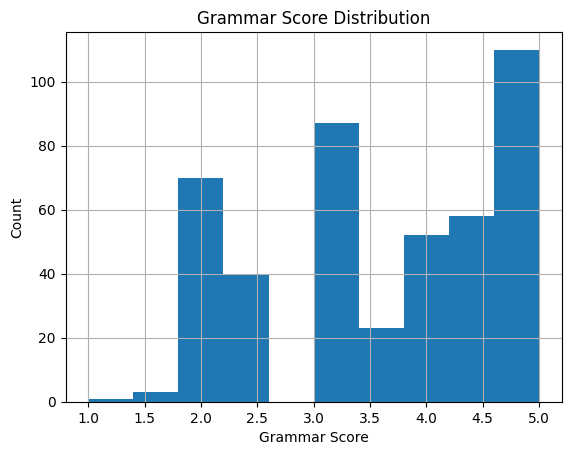

In [53]:
train_df['label'].hist(bins=10)
plt.title('Grammar Score Distribution')
plt.xlabel('Grammar Score')
plt.ylabel('Count')
plt.show()


# Feature Extraction Function

In [84]:
import librosa
import numpy as np
import librosa
import numpy as np

def extract_strong_features(audio_path, sr=22050, n_mfcc=30):
    audio, sr = librosa.load(audio_path, sr=sr)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    delta1 = librosa.feature.delta(mfccs)
    delta2 = librosa.feature.delta(mfccs, order=2)

    # Pitch
    pitch, _ = librosa.piptrack(y=audio, sr=sr)
    pitches = pitch[pitch > 0]

    # Core spectral features
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    rmse = librosa.feature.rms(y=audio)
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

    features = np.concatenate([
        np.mean(mfccs, axis=1),
        np.std(mfccs, axis=1),
        np.mean(delta1, axis=1),
        np.mean(delta2, axis=1),
        [np.mean(zcr), np.std(zcr)],
        [np.mean(rmse), np.std(rmse)],
        [np.mean(centroid), np.std(centroid)],
        [np.mean(rolloff), np.std(rolloff)],
        [np.mean(bandwidth), np.std(bandwidth)],
        np.mean(chroma, axis=1),
        [np.mean(pitches) if pitches.size > 0 else 0,
         np.std(pitches) if pitches.size > 0 else 0]
    ])
    return features



# Process & Save the features

In [85]:
from tqdm import tqdm

X, y = [], []

for index, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Extracting features"):
    audio_path = f"dataset/dataset/audios_train/{row['filename']}"
    feats = extract_features(audio_path)
    X.append(feats)
    y.append(row['label'])

X = np.array(X)
y = np.array(y)


Extracting features: 100%|███████████████████████████████████████████████████████████| 444/444 [06:52<00:00,  1.08it/s]


# Implementing the XGBRegressor

In [91]:
!pip install --upgrade pip



  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\VEDANSHI\\AppData\\Local\\Temp\\pip-uninstall-5lhc82_b\\pip.exe'
Check the permissions.



In [96]:
!pip install --upgrade xgboost


In [100]:

from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.5,
    reg_lambda=0.5,
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_val)


corr, _ = pearsonr(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"XGBoost Pearson Correlation: {corr:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}") 


XGBoost Pearson Correlation: 0.6212
RMSE: 0.9191
MAE: 0.7168


# Plotting the Actual values

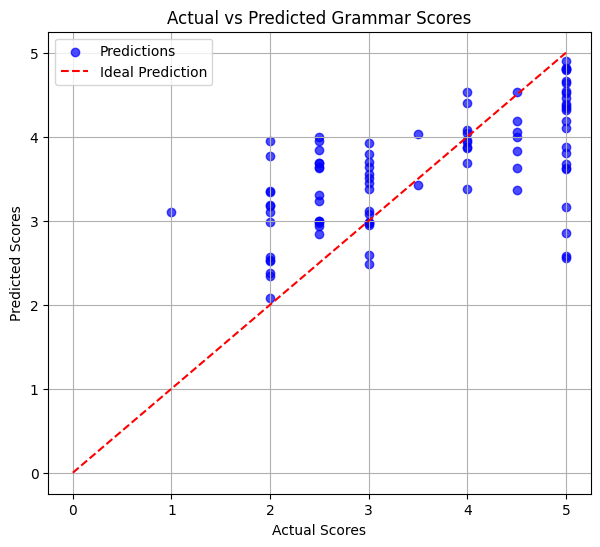

In [80]:
plt.figure(figsize=(7,6))
plt.scatter(y_val, y_pred, alpha=0.7, c='blue', label='Predictions')
plt.plot([0,5],[0,5],'r--', label='Ideal Prediction')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Grammar Scores')
plt.legend()
plt.grid(True)
plt.show()


# Process and save the test features

In [81]:

from tqdm import tqdm

test_features = []

for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Extracting test features"):
    audio_path = f"dataset/dataset/audios_test/{row['filename']}"
    feats = extract_features(audio_path)
    test_features.append(feats)

X_test = np.array(test_features)
predictions = model.predict(X_test)



In [82]:
submission = pd.read_csv('dataset/dataset/sample_submission.csv')
submission['label'] = predictions
submission.to_csv('submission.csv', index=False)

In [83]:
import os
print(os.path.abspath('submission.csv'))


C:\Users\VEDANSHI\submission.csv
